# Imports and files

In [1]:
from pathlib import Path

import pandas as pd

from sainsc import GridCounts, LazyKDE
from sainsc.io import read_gem_file

In [26]:
# input
data_path = Path("data")
novast_file = data_path / "NovaST" / "GSM8093729_Replicate_1.gem.txt.gz"

signatures_file = Path(".") / "StereoSeq_Brain_segmentation_signatures.tsv"
de_genes_file = data_path / "ABC_atlas" / "DE_genes.xlsx"
celltype_color_file = "colormap_brain_publication.json"

# output
analysis_path = Path("NovaST")

In [6]:
genes = (
    pd.read_excel(de_genes_file, sheet_name="DE_gene_list", header=None, names=["gene"])
    .loc[:, "gene"]
    .tolist()
)

len(genes)

8460

In [7]:
analysis_path.mkdir(exist_ok=True, parents=True)

# Preprocess Nova-ST

In [8]:
n_threads = 16

novast_brain = LazyKDE(
    GridCounts.from_dataframe(
        read_gem_file(novast_file, n_threads=n_threads),
        binsize=728 / 50,  # according to methods of NovaST paper
    ),
    n_threads=n_threads,
)

novast_brain.resolution = 500

print(novast_brain)

LazyKDE (16 threads)
    genes: 25727
    shape: (14301, 31578)
    resolution: 500.0 nm / px


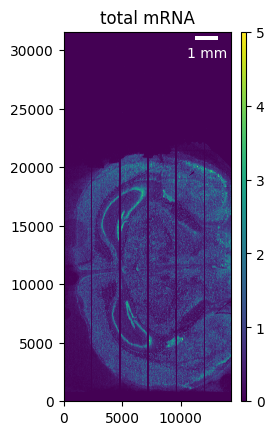

In [9]:
novast_brain.calculate_total_mRNA()

_ = novast_brain.plot_genecount(im_kwargs={"vmax": 5})

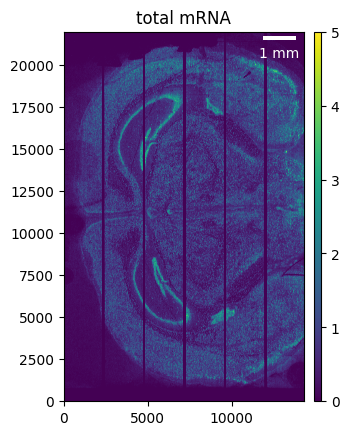

In [10]:
novast_brain.counts.crop((None, None), (None, 22_000))

novast_brain.calculate_total_mRNA()

_ = novast_brain.plot_genecount(im_kwargs={"vmax": 5})

In [11]:
novast_brain.gaussian_kernel(8)

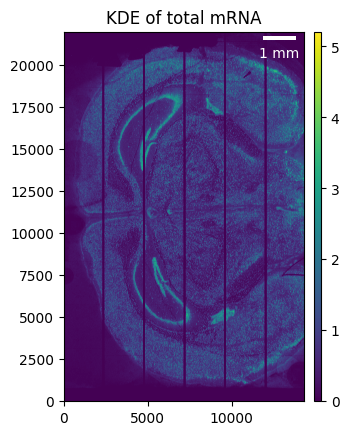

In [12]:
novast_brain.calculate_total_mRNA_KDE()

_ = novast_brain.plot_KDE()

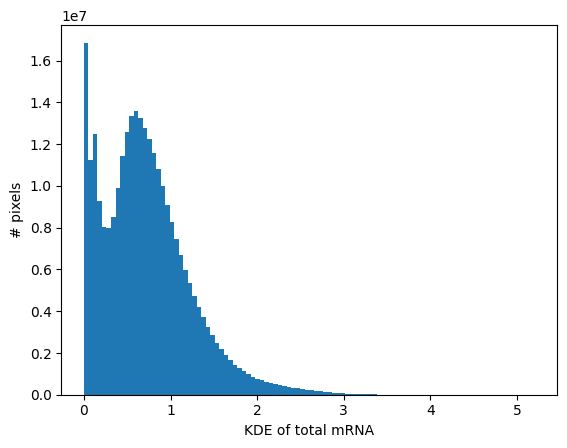

In [13]:
_ = novast_brain.plot_KDE_histogram(bins=100)

In [14]:
novast_brain.filter_background(0.4)

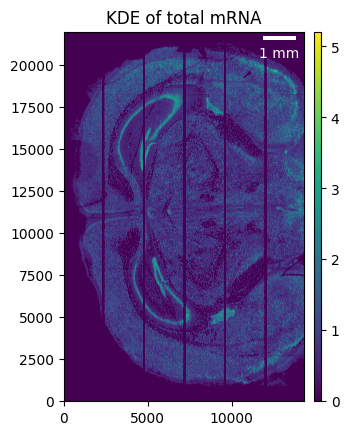

In [15]:
_ = novast_brain.plot_KDE(remove_background=True)

# Cell-type map

In [16]:
signatures = pd.read_table(signatures_file, index_col=0).loc[
    lambda df: df.index.isin(genes) & df.index.isin(novast_brain.genes)
]

signatures.shape

(7918, 29)

In [17]:
print(novast_brain)

LazyKDE (16 threads)
    genes: 25727
    shape: (14301, 22000)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set


In [18]:
novast_brain.assign_celltype(signatures, log=True)

In [27]:
import json

with open(celltype_color_file, "r") as f:
    cmap = json.load(f)

In [36]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": novast_brain.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            novast_brain.celltype_map.flatten(), categories=novast_brain.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.4

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

novast_brain.filter_background(celltype_threshold)

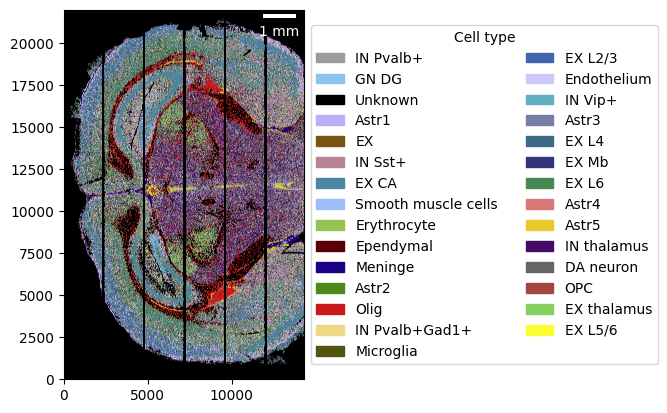

In [37]:
_ = novast_brain.plot_celltypemap(remove_background=True, cmap=cmap)

In [38]:
im = novast_brain.plot_celltypemap(
    remove_background=True, cmap=cmap, return_img=True, background="white"
)

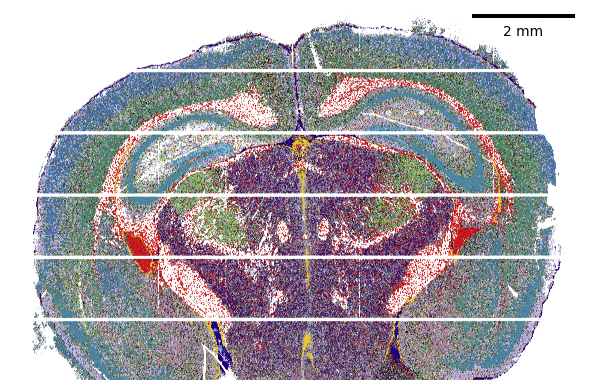

In [46]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(6, 4))

_ = ax.imshow(im.transpose(1, 0, 2))
_ = ax.set_axis_off()
_ = ax.add_artist(
    ScaleBar(500, **{"units": "nm", "box_alpha": 0, "location": "upper right"})
)
fig.tight_layout()

In [47]:
fig.savefig("figures/NovaST.pdf", dpi=600)